Intro

### **1. Initiate libraries and paths**

In [1]:
import fitz
import PyPDF2
from transformers import pipeline
import os
from glob import glob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Folder paths for txt files
abstracts_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Abstracts'
pdf_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature'

c:\Users\bart_\anaconda3\envs\llms\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **2. Create word cloud**

In [2]:
# Load text from all txt files
abstract_texts = []
for file in glob(os.path.join(abstracts_folder, "*.txt")):
    with open(file, 'r', encoding='utf-8') as f:
        abstract_texts.append(f.read())

# Join all abstracts into one text for word cloud generation
all_abstracts_text = " ".join(abstract_texts)

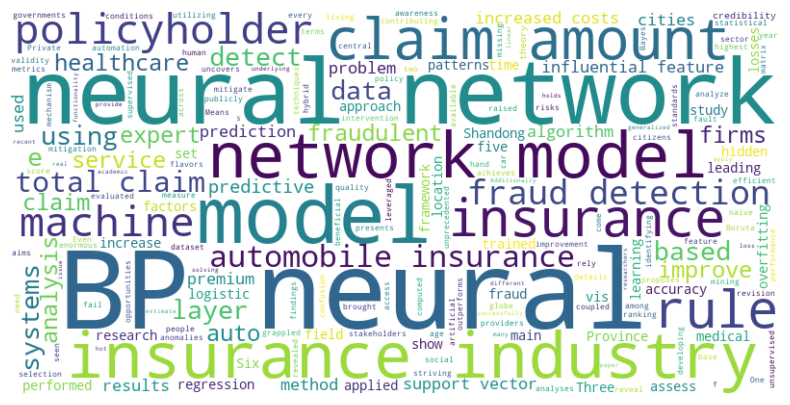

In [3]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_abstracts_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **3. Word counter on words of interest**

In [ ]:
# Initiate empty dict
pdf_texts = {}

# Use glob to recursively find all PDFs in subfolders
for file in glob(os.path.join(pdf_folder, "**", "*.pdf"), recursive=True):
    pdf_text = ""
    with open(file, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            pdf_text += pdf_reader.pages[page_num].extract_text()
    
    # Extract the subfolder name
    subfolder_name = os.path.basename(os.path.dirname(file))

    # Store
    pdf_texts[(os.path.basename(file), subfolder_name)] = pdf_text

In [19]:
# List of insurance-related words
interest_words = [
    'neural network'
    , 'gbm'
    , 'xgboost'
    , 'random forest'
    , 'explainability'
    , 'xai'
    , 'fairness'
    , 'lime'
    , 'shapley'
    , 'interpretability']

In [20]:
# Count words in each PDF text
pdf_word_counts = []
for (filename, subfolder), text in pdf_texts.items():
    word_count = Counter(word.lower() for word in text.split())
    count_data = {word: word_count[word] for word in interest_words}
    
    # Add the filename and subfolder name to the count data
    count_data['title'] = filename
    count_data['subdomain'] = subfolder
    
    pdf_word_counts.append(count_data)

# Convert to DataFrame for visualization
df_word_counts = pd.DataFrame(pdf_word_counts)

In [21]:
df_word_counts

,neural network,gbm,xgboost,random forest,explainability,xai,fairness,lime,shapley,interpretability,title,subdomain
0,0,0,0,0,0,0,0,0,0,0,Application_of_Improved_PSO-ELM_in_Auto_Insura...,Literature
1,0,0,0,0,0,0,0,0,0,0,How-to conduct a systematic literature review-...,Literature
2,0,0,0,0,0,0,0,0,0,0,knowledge graphs.pdf,Literature
3,0,0,0,0,0,0,0,0,0,0,research_methods.pdf,Literature
4,0,0,0,0,3,0,5,0,0,3,Advanced+AI+Techniques+for+Optimizing+Claims+M...,Claims
5,0,0,0,0,1,1,3,0,0,2,AI-Enhanced+Claims+Processing+in+Insurance.pdf,Claims
6,0,0,0,0,2,0,4,0,0,0,AI-Powered+Techniques+for+Claims+Triage+in+Pro...,Claims
7,0,0,0,0,0,0,0,0,0,0,Automatic damaged vehicle estimator using enha...,Claims
8,0,0,0,0,0,0,0,0,0,0,Automating_Car_Insurance_Claims_Using_Deep_Lea...,Claims
9,0,0,0,0,0,0,0,0,0,0,CarDamage-ConferencePaper.pdf,Claims
